## Work
1. 請比較 SGD optimizer 不同的 momentum 及使用 nesterov 與否的表現

In [1]:
import os
import tensorflow.keras as keras

# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

/Users/ttyoung/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [25]:
train, test = keras.datasets.cifar10.load_data()

In [15]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [24]:
# x_train.shape

In [16]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [26]:
x_train = x_train[:5000]
x_test = x_test[:5000]
y_train = y_train[:5000]
y_test = y_test[:5000]

In [27]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [28]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = [1e-1, 1e-2]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = [1e-1, 1e-2]
NESTEROV = [False,True]


In [29]:
import itertools
list(itertools.product(LEARNING_RATE,MOMENTUM,NESTEROV))

[(0.1, 0.1, False),
 (0.1, 0.1, True),
 (0.1, 0.01, False),
 (0.1, 0.01, True),
 (0.01, 0.1, False),
 (0.01, 0.1, True),
 (0.01, 0.01, False),
 (0.01, 0.01, True)]

In [31]:
results = {}
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
for lr, momentum, nesterov in list(itertools.product(LEARNING_RATE,MOMENTUM,NESTEROV)):
    try:
        keras.backend.clear_session() # 把舊的 Graph 清掉
    except:
        pass
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=lr, nesterov=nesterov, momentum=momentum)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-lr-{lr}-momentum-{momentum}-{nesterov}".format(lr=lr, momentum= momentum, nesterov=nesterov )
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with LR = 0.100000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 5000 samples, validate on 5000 samples
Epoch 1/50
5000/5000 [==============================] 

Train on 5000 samples, validate on 5000 samples
Epoch 1/50
5000/5000 [==============================] - 1s 271us/step - loss: 2.2765 - acc: 0.1494 - val_loss: 2.2378 - val_acc: 0.1852
Epoch 2/50
5000/5000 [==============================] - 1s 265us/step - loss: 2.1761 - acc: 0.1938 - val_loss: 2.2818 - val_acc: 0.1312
Epoch 3/50
5000/5000 [==============================] - 1s 196us/step - loss: 2.1124 - acc: 0.2242 - val_loss: 2.1219 - val_acc: 0.2016
Epoch 4/50
5000/5000 [==============================] - 1s 218us/step - loss: 2.0226 - acc: 0.2524 - val_loss: 2.0814 - val_acc: 0.2216
Epoch 5/50
5000/5000 [==============================] - 1s 217us/step - loss: 2.0035 - acc: 0.2708 - val_loss: 1.9208 - val_acc: 0.3080
Epoch 6/50
5000/5000 [==============================] - 1s 229us/step - loss: 1.9546 - acc: 0.2940 - val_loss: 2.0305 - val_acc: 0.2542
Epoch 7/50
5000/5000 [==============================] - 1s 265us/step - loss: 1.9964 - acc: 0.2896 - val_loss: 1.9731 - val_acc: 0.2828


5000/5000 [==============================] - 1s 184us/step - loss: 2.0412 - acc: 0.2656 - val_loss: 2.3016 - val_acc: 0.1768
Epoch 5/50
5000/5000 [==============================] - 1s 230us/step - loss: 2.0409 - acc: 0.2514 - val_loss: 2.1471 - val_acc: 0.2012
Epoch 6/50
5000/5000 [==============================] - 1s 217us/step - loss: 2.0073 - acc: 0.2698 - val_loss: 1.9209 - val_acc: 0.3150
Epoch 7/50
5000/5000 [==============================] - 1s 211us/step - loss: 1.9221 - acc: 0.3022 - val_loss: 1.9586 - val_acc: 0.3162
Epoch 8/50
5000/5000 [==============================] - 1s 196us/step - loss: 1.9030 - acc: 0.3120 - val_loss: 2.0675 - val_acc: 0.2518
Epoch 9/50
5000/5000 [==============================] - 1s 236us/step - loss: 1.8896 - acc: 0.3220 - val_loss: 1.8911 - val_acc: 0.3248
Epoch 10/50
5000/5000 [==============================] - 1s 183us/step - loss: 1.8620 - acc: 0.3294 - val_loss: 1.9312 - val_acc: 0.3394
Epoch 11/50
5000/5000 [==============================] - 1

5000/5000 [==============================] - 1s 175us/step - loss: 1.9236 - acc: 0.3158 - val_loss: 2.0050 - val_acc: 0.2834
Epoch 9/50
5000/5000 [==============================] - 1s 178us/step - loss: 1.9058 - acc: 0.3240 - val_loss: 1.9236 - val_acc: 0.3272
Epoch 10/50
5000/5000 [==============================] - 1s 179us/step - loss: 1.8787 - acc: 0.3408 - val_loss: 1.9209 - val_acc: 0.3056
Epoch 11/50
5000/5000 [==============================] - 1s 176us/step - loss: 1.8640 - acc: 0.3376 - val_loss: 1.8900 - val_acc: 0.3372
Epoch 12/50
5000/5000 [==============================] - 1s 179us/step - loss: 1.8621 - acc: 0.3396 - val_loss: 1.9658 - val_acc: 0.2978
Epoch 13/50
5000/5000 [==============================] - 1s 179us/step - loss: 1.8420 - acc: 0.3494 - val_loss: 1.9067 - val_acc: 0.3198
Epoch 14/50
5000/5000 [==============================] - 1s 177us/step - loss: 1.8269 - acc: 0.3588 - val_loss: 1.9264 - val_acc: 0.3240
Epoch 15/50
5000/5000 [==============================]

5000/5000 [==============================] - 1s 192us/step - loss: 1.8484 - acc: 0.3484 - val_loss: 1.9107 - val_acc: 0.3200
Epoch 13/50
5000/5000 [==============================] - 1s 208us/step - loss: 1.8347 - acc: 0.3580 - val_loss: 1.9291 - val_acc: 0.3258
Epoch 14/50
5000/5000 [==============================] - 1s 236us/step - loss: 1.8372 - acc: 0.3482 - val_loss: 1.8720 - val_acc: 0.3424
Epoch 15/50
5000/5000 [==============================] - 1s 185us/step - loss: 1.8098 - acc: 0.3604 - val_loss: 1.8659 - val_acc: 0.3342
Epoch 16/50
5000/5000 [==============================] - 1s 182us/step - loss: 1.7970 - acc: 0.3648 - val_loss: 1.8667 - val_acc: 0.3326
Epoch 17/50
5000/5000 [==============================] - 1s 183us/step - loss: 1.7936 - acc: 0.3692 - val_loss: 1.8572 - val_acc: 0.3350
Epoch 18/50
5000/5000 [==============================] - 1s 192us/step - loss: 1.7783 - acc: 0.3786 - val_loss: 1.8609 - val_acc: 0.3240
Epoch 19/50
5000/5000 [==============================

In [33]:
for i, cond in enumerate(results.keys()):
    print(i)

0
1
2
3
4
5
6
7


In [34]:
import matplotlib.colors as colors
colors_list = list(colors._colors_full_map.values())


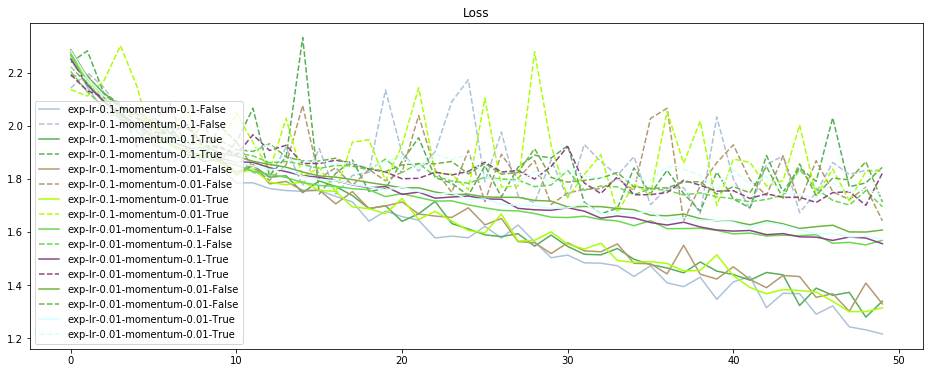

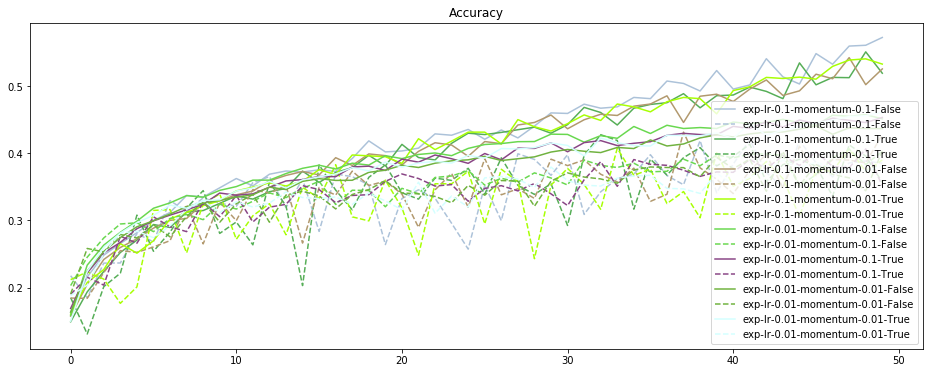

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = colors_list

plt.figure(figsize=(16,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()